<a href="https://www.kaggle.com/code/yxyyxy/isic-2024-draft?scriptVersionId=193982603" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## This notebook uses the ISIC dataset, which includes all images and metadata in the ISIC archive (https://www.kaggle.com/datasets/tomooinubushi/all-isic-data-20240629).

### Dataset Details
- **Dataset Name**: All ISIC Data 20240629
- **Description**: All images and metadata in ISIC archive.
- **Download Size**: 79 GB
- **Source**: ISIC Archive

### Image Formats
- `image.hdf`: Images in hdf5 format with no postprocessing
- `image_256sq.hdf`: Images in hdf5 format with square cropping and resizing to 256x256

## This notebook is based on the work by motono0223, titled “ISIC: Tabular model + Image model features” (https://www.kaggle.com/code/motono0223/isic-tabular-model-image-model-features)
The original notebook utilizes resources from the following datasets: “ISIC 2024 - Skin Cancer Detection with 3D-TBP,” “[ISIC] Pytorch Training Baseline (Image only),” and “[ISIC] Pytorch Training Baseline (EVA02).” The original work has been edited and adapted for this notebook. 
## The tabular learning is modified according to notebook https://www.kaggle.com/code/greysky/isic-2024-only-tabular-data/notebook  

In [1]:
import numpy as np
import pandas as pd
import pandas.api.types
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import catboost as cb
import lightgbm as lgb
import xgboost as xgb
from tqdm.auto import tqdm
import gc

import os
import joblib
from pathlib import Path
import polars as pl

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm

import h5py
from PIL import Image
from io import BytesIO

In [2]:
CONFIG = {
    "img_size": 224,
    "valid_batch_size": 32,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "flag_useCV": True,
}

BEST_WEIGHT_eff = "/kaggle/input/all-isic-image-dataset-efficientnet-baseline/best_fold_0.bin"
BEST_WEIGHT_eva = "/kaggle/input/all-isic-image-dataset-eva02-baseline/AUROC0.1621_Loss0.0853_epoch2.bin"


In [3]:
def set_seed(seed=1):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(1)

# Load tf_efficientnet_b0_ns model

In [4]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'
    
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.sigmoid(self.linear(pooled_features))
        return output

if CONFIG["flag_useCV"]:
    model_eff = ISICModel('tf_efficientnet_b0_ns', pretrained=False)

    # Load the weights into the model
    with torch.no_grad():
        model_eff.load_state_dict(torch.load(BEST_WEIGHT_eff, map_location=CONFIG['device']))
        model_eff.to(CONFIG['device'])
        

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


# Load EVA02 model

In [5]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

        # Check if the model has a head or fc attribute
        if hasattr(self.model, 'fc') and not isinstance(self.model.fc, nn.Identity):
            in_features = self.model.fc.in_features
            self.model.fc = nn.Linear(in_features, num_classes)
        elif hasattr(self.model, 'head') and not isinstance(self.model.head, nn.Identity):
            in_features = self.model.head.in_features
            self.model.head = nn.Linear(in_features, num_classes)
        else:
            # If the model has an Identity head, add a new head
            in_features = self.model.num_features
            self.model.head = nn.Linear(in_features, num_classes)

        self.activation = nn.Sigmoid() if num_classes == 1 else nn.Softmax(dim=1)

    def forward(self, images):
        return self.activation(self.model(images))

if CONFIG["flag_useCV"]:
    model_eva = ISICModel("eva02_base_patch14_224", pretrained=False)
    # Load the weights into the model
    with torch.no_grad():
        model_eva.load_state_dict(torch.load(BEST_WEIGHT_eva, map_location=CONFIG['device']))
        model_eva.to(CONFIG['device'])

In [6]:
if CONFIG["flag_useCV"]:
    # # Image features (training data)
    df_eff = pd.read_csv("/kaggle/input/all-isic-image-dataset-efficientnet-baseline/train_effnetv1b0_prob.csv")
    df_eva = pd.read_csv("/kaggle/input/all-isic-image-dataset-eva02-baseline/eva02_base_patch14_224_prob.csv")
     
    gc.collect()


In [7]:
df_eva.head()

,eva02_base_patch14_224,data_source,target,isic_id
0,0.000002,/kaggle/input/isic-2024-challenge/train-image/...,0.0,ISIC_0015670
1,0.000033,/kaggle/input/isic-2024-challenge/train-image/...,0.0,ISIC_0015845
2,0.000002,/kaggle/input/isic-2024-challenge/train-image/...,0.0,ISIC_0015864
3,0.000002,/kaggle/input/isic-2024-challenge/train-image/...,0.0,ISIC_0015902
4,0.000001,/kaggle/input/isic-2024-challenge/train-image/...,0.0,ISIC_0024200


# Load Input

In [8]:
ROOT_DIR = Path('/kaggle/input/isic-2024-challenge')

TRAIN_CSV = ROOT_DIR / 'train-metadata.csv'
TEST_CSV = f'{ROOT_DIR}/test-metadata.csv'
TEST_HDF = f'{ROOT_DIR}/test-image.hdf5'
SAMPLE = f'{ROOT_DIR}/sample_submission.csv'

In [9]:
id_col = 'isic_id'
target_col = 'target'
group_col = 'patient_id'

err = 1e-5
sampling_ratio = 0.01
seed = 42

num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+ 
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]

new_num_cols = [
    'lesion_size_ratio',             # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
    'lesion_shape_index',            # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
    'hue_contrast',                  # tbp_lv_H                - tbp_lv_Hext              abs
    'luminance_contrast',            # tbp_lv_L                - tbp_lv_Lext              abs
    'lesion_color_difference',       # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt  
    'border_complexity',             # tbp_lv_norm_border      + tbp_lv_symm_2axis
    'color_uniformity',              # tbp_lv_color_std_mean   / tbp_lv_radial_color_std_max

    'position_distance_3d',          # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
    'perimeter_to_area_ratio',       # tbp_lv_perimeterMM      / tbp_lv_areaMM2
    'area_to_perimeter_ratio',       # tbp_lv_areaMM2          / tbp_lv_perimeterMM
    'lesion_visibility_score',       # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
    'symmetry_border_consistency',   # tbp_lv_symm_2axis       * tbp_lv_norm_border
    'consistency_symmetry_border',   # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

    'color_consistency',             # tbp_lv_stdL             / tbp_lv_Lext
    'consistency_color',             # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
    'size_age_interaction',          # clin_size_long_diam_mm  * age_approx
    'hue_color_std_interaction',     # tbp_lv_H                * tbp_lv_color_std_mean
    'lesion_severity_index',         # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
    'shape_complexity_index',        # border_complexity       + lesion_shape_index
    'color_contrast_index',          # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

    'log_lesion_area',               # tbp_lv_areaMM2          + 1  np.log
    'normalized_lesion_size',        # clin_size_long_diam_mm  / age_approx
    'mean_hue_difference',           # tbp_lv_H                + tbp_lv_Hext    / 2
    'std_dev_contrast',              # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
    'color_shape_composite_index',   # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
    'lesion_orientation_3d',         # tbp_lv_y                , tbp_lv_x  np.arctan2
    'overall_color_difference',      # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

    'symmetry_perimeter_interaction',# tbp_lv_symm_2axis       * tbp_lv_perimeterMM
    'comprehensive_lesion_index',    # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
    'color_variance_ratio',          # tbp_lv_color_std_mean   / tbp_lv_stdLExt
    'border_color_interaction',      # tbp_lv_norm_border      * tbp_lv_norm_color
    'border_color_interaction_2',
    'size_color_contrast_ratio',     # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
    'age_normalized_nevi_confidence',# tbp_lv_nevi_confidence  / age_approx
    'age_normalized_nevi_confidence_2',
    'color_asymmetry_index',         # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

    'volume_approximation_3d',       # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
    'color_range',                   # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
    'shape_color_consistency',       # tbp_lv_eccentricity     * tbp_lv_color_std_mean
    'border_length_ratio',           # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
    'age_size_symmetry_index',       # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
    'index_age_size_symmetry',       # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis
]

cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']
norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
special_cols = ['count_per_patient']
feature_cols = num_cols + new_num_cols + cat_cols + norm_cols + special_cols

print("number of cat_cols: ", len(cat_cols))
print("number of features: ", len(feature_cols))


number of cat_cols:  6
number of features:  159


In [10]:
# Feature Engineering
def read_data(path):
    return (
        pl.read_csv(path)
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()), # You may want to impute test data with train
        )
        .with_columns(
            lesion_size_ratio              = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index             = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast                   = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast             = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference        = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity              = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity               = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + err),
        )
        .with_columns(
            position_distance_3d           = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio        = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio        = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score        = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            combined_anatomical_site       = pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location'),
            symmetry_border_consistency    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
        )
        .with_columns(
            color_consistency              = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color              = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
            size_age_interaction           = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction      = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index          = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index         = pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index           = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )
        .with_columns(
            log_lesion_area                = (pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size         = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference            = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast               = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index    = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d          = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference       = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )
        .with_columns(
            symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
            size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            volume_approximation_3d        = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range                    = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency        = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio            = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index        = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry        = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + err)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        )
        .with_columns(
            count_per_patient = pl.col('isic_id').count().over('patient_id'),
        )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        .set_index(id_col)
    )

def preprocess(df_train, df_test):
    global cat_cols
    
#     print("number of cat_cols: ", len(cat_cols))
    
    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])
    
    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]
    
    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('category')
    
    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('category')
    
    for col in cat_cols:
        feature_cols.remove(col)
    
    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols
    
 
    return df_train, df_test

df_train = read_data(TRAIN_CSV)
df_test = read_data(TEST_CSV)


In [11]:
# Reset the index of df_train to a RangeIndex to fit the df_eff and df_eva
df_train.reset_index(inplace=True)


In [12]:
import ast

def convert_to_float(value):
    if isinstance(value, str):
        # Convert string representation of list to actual list
        value = ast.literal_eval(value)
    return float(value[0])

if CONFIG["flag_useCV"]:
    df_train["target_effnetv1b0"] = df_eff["target_effnetv1b0"].apply(convert_to_float)
    df_train["target_eva02"] = df_eva["eva02_base_patch14_224"]

    feature_cols += ["target_effnetv1b0", "target_eva02"]
#     del df_eff, df_eva

    gc.collect()
    

In [13]:
# preprocess after add the image results
df_train, df_test = preprocess(df_train, df_test)

if CONFIG["flag_useCV"]:
    # Create new columns and set their values to 0
    df_test["target_effnetv1b0"] = 0
    df_test["target_eva02"] = 0


In [14]:
# List of unique top features -- obtained from importance analysis
unique_top_features = [
    'age_approx_patient_norm', 'age_normalized_nevi_confidence_2_patient_norm',
    'border_length_ratio', 'clin_size_long_diam_mm',
    'clin_size_long_diam_mm_patient_norm', 'color_uniformity_patient_norm',
    'count_per_patient', 'hue_contrast', 'lesion_orientation_3d',
    'log_lesion_area_patient_norm', 'normalized_lesion_size_patient_norm',
    'overall_color_difference_patient_norm', 'position_distance_3d_patient_norm',
    'size_age_interaction_patient_norm', 'target_effnetv1b0', 'target_eva02',
    'tbp_lv_H', 'tbp_lv_H_patient_norm', 'tbp_lv_areaMM2', 'tbp_lv_deltaLBnorm',
    'tbp_lv_stdLExt', 'tbp_lv_y_patient_norm'
]

# Keep only the specified columns in df_train and df_test
# feature_cols = unique_top_features


In [15]:
# # Describe the DataFrame
# print(df_train.describe())

# # Print the counts of NaN values
# nan_counts = df_train.isna().sum()
# print("\nCounts of NaN values in each column:")
# print(nan_counts)


In [16]:
df = pd.read_csv(TEST_CSV)
# df.isic_id


In [17]:
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc


In [18]:
# LGBM Model
lgb_params =  {
    'objective':        'binary',
    'verbosity':        -1,
    'n_estimators':     200,
    'boosting_type':    'gbdt',
    'random_state':     1,
    'lambda_l1':        0.08758718919397321, 
    'lambda_l2':        0.0039689175176025465, 
    'learning_rate':    0.03231007103195577, 
    'max_depth':        4, 
    'num_leaves':       103, 
    'colsample_bytree': 0.8329551585827726, 
    'colsample_bynode': 0.4025961355653304, 
    'bagging_fraction': 0.7738954452473223, 
    'bagging_freq':     4, 
    'min_data_in_leaf': 85, 
    'scale_pos_weight': 2.7984184778875543,
}
lgb_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=1)),
    ('classifier', lgb.LGBMClassifier(**lgb_params)),
])
    


In [19]:
# Catboost Model
cb_params = {
    'loss_function':     'Logloss',
    'iterations':        200,
    'verbose':           False,
    'random_state':      1,
    'max_depth':         7, 
    'learning_rate':     0.06936242010150652, 
    'scale_pos_weight':  2.6149345838209532, 
    'l2_leaf_reg':       6.216113851699493, 
    'subsample':         0.6249261779711819, 
    'min_data_in_leaf':  24,
    'cat_features':      cat_cols,
}
cb_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=1)),
    ('classifier', cb.CatBoostClassifier(**cb_params)),
])


In [20]:
xgb_params = {
    'enable_categorical': True,
    'tree_method':        'hist',
    'random_state':       1,
    'learning_rate':      0.08501257473292347, 
    'lambda':             8.879624125465703, 
    'alpha':              0.6779926606782505, 
    'max_depth':          6, 
    'subsample':          0.6012681388711075, 
    'colsample_bytree':   0.8437772277074493, 
    'colsample_bylevel':  0.5476090898823716, 
    'colsample_bynode':   0.9928601203635129, 
    'scale_pos_weight':   3.29440313334688,
    'train_dir':          None,  # Add this line
}

xgb_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=1)),
    ('classifier', xgb.XGBClassifier(**xgb_params)),
])


# Training

In [21]:
# Define the VotingClassifier soft weights adopted from https://www.kaggle.com/code/vyacheslavbolotin/isic-2024-parallel-image-lines-4-lines/notebook?scriptVersionId=193187870
estimator = VotingClassifier([
    ('lgb', lgb_model), ('cb', cb_model), ('xgb', xgb_model),
], voting='soft',weights=[0.30,0.47,0.28])

X_train = df_train[feature_cols]
y_train = df_train[target_col]
groups = df_train[group_col]
cv = StratifiedGroupKFold(5, shuffle=True, random_state=1)

# Initialize list to store pAUC for each fold
pauc_scores = []

# Cross-validation with evaluation
for train_idx, val_idx in cv.split(X_train, y_train, groups):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit the estimator
    estimator.fit(X_train_fold, y_train_fold)
    # Calculate pAUC on the validation fold
    pauc = custom_metric(estimator, X_val_fold, y_val_fold)
    # Append pAUC to list
    pauc_scores.append(pauc)

# Print the average pAUC
print(f"Average pAUC: {np.mean(pauc_scores):.4f}")

Average pAUC: 0.1989


# Feature Importance Analysis

In [22]:
# Fit each individual model
lgb_model.fit(X_train, y_train)
cb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)


Pipeline(steps=[('sampler',
                 RandomUnderSampler(random_state=1, sampling_strategy=0.01)),
                ('classifier',
                 XGBClassifier(alpha=0.6779926606782505, base_score=None,
                               booster=None, callbacks=None,
                               colsample_bylevel=0.5476090898823716,
                               colsample_bynode=0.9928601203635129,
                               colsample_bytree=0.8437772277074493, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               lambda=8.879624125465703,
                               learning_rate=0.08501257473292347, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, ...))])

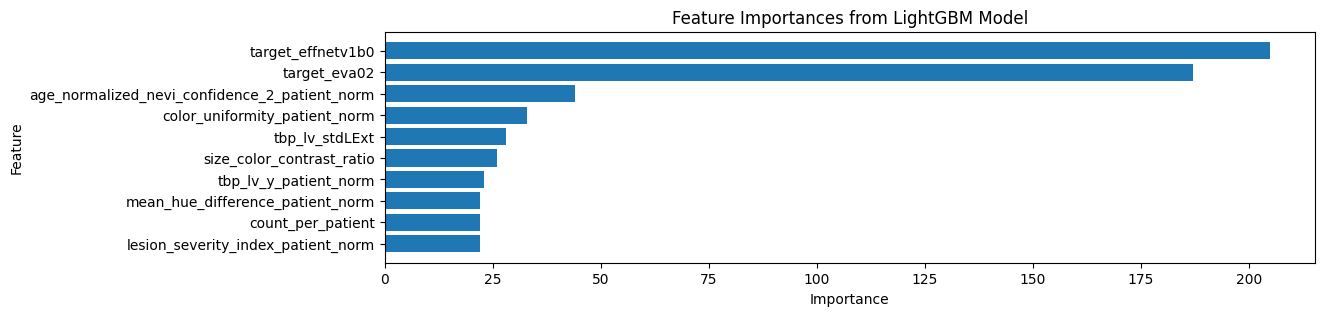

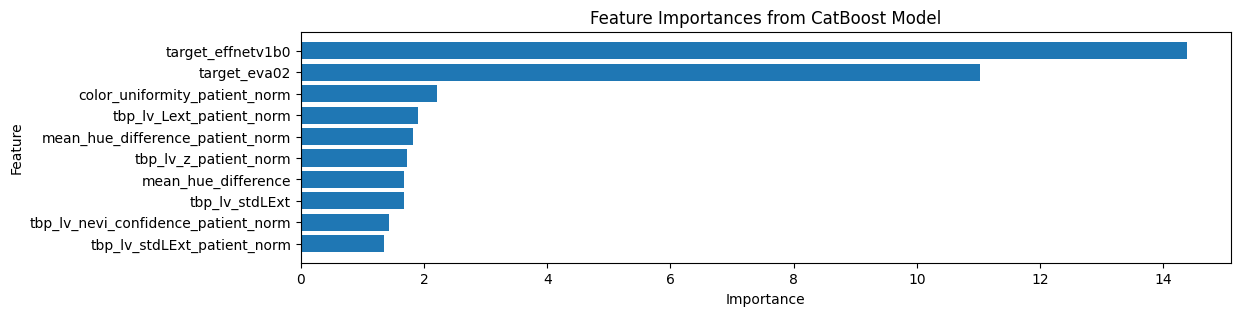

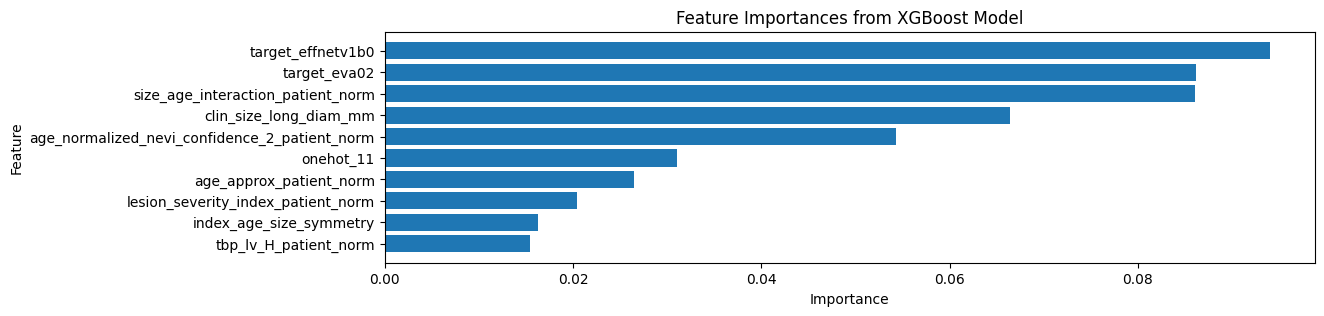

Top 10 features for LightGBM: ['target_effnetv1b0' 'target_eva02'
 'age_normalized_nevi_confidence_2_patient_norm'
 'color_uniformity_patient_norm' 'tbp_lv_stdLExt'
 'size_color_contrast_ratio' 'tbp_lv_y_patient_norm'
 'mean_hue_difference_patient_norm' 'count_per_patient'
 'lesion_severity_index_patient_norm']
Top 10 features for CatBoost: ['target_effnetv1b0' 'target_eva02' 'color_uniformity_patient_norm'
 'tbp_lv_Lext_patient_norm' 'mean_hue_difference_patient_norm'
 'tbp_lv_z_patient_norm' 'mean_hue_difference' 'tbp_lv_stdLExt'
 'tbp_lv_nevi_confidence_patient_norm' 'tbp_lv_stdLExt_patient_norm']
Top 10 features for XGBoost: ['target_effnetv1b0' 'target_eva02' 'size_age_interaction_patient_norm'
 'clin_size_long_diam_mm' 'age_normalized_nevi_confidence_2_patient_norm'
 'onehot_11' 'age_approx_patient_norm'
 'lesion_severity_index_patient_norm' 'index_age_size_symmetry'
 'tbp_lv_H_patient_norm']
Unique top features across all models: ['age_approx_patient_norm' 'age_normalized_nevi_c

In [23]:
# Plot the feature importances for each model
def plot_feature_importances(importances, model_name, top_n=None):
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = np.array(feature_cols)[sorted_idx]
    sorted_importances = importances[sorted_idx]

    if top_n is not None:
        sorted_features = sorted_features[:top_n]
        sorted_importances = sorted_importances[:top_n]

    plt.figure(figsize=(12, 3))
    plt.barh(sorted_features, sorted_importances)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(f"Feature Importances from {model_name} Model")
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
    plt.show()

    # Function to get top N features
def get_top_features(importances, feature_cols, top_n=10):
    sorted_idx = np.argsort(importances)[::-1]
    top_features = np.array(feature_cols)[sorted_idx][:top_n]
    return top_features

# Extract feature importances from each model within the pipeline
lgb_importances = lgb_model.named_steps['classifier'].feature_importances_
cb_importances = cb_model.named_steps['classifier'].feature_importances_
xgb_importances = xgb_model.named_steps['classifier'].feature_importances_

# Plot for LightGBM
plot_feature_importances(lgb_importances, "LightGBM", top_n=10)
# Plot for CatBoost
plot_feature_importances(cb_importances, "CatBoost", top_n=10)
# Plot for XGBoost
plot_feature_importances(xgb_importances, "XGBoost", top_n=10)

# Get top 10 features for each model
top_lgb_features = get_top_features(lgb_importances, feature_cols, top_n=10)
top_cb_features = get_top_features(cb_importances, feature_cols, top_n=10)
top_xgb_features = get_top_features(xgb_importances, feature_cols, top_n=10)

# Merge the features and remove duplicates
all_top_features = np.concatenate([top_lgb_features, top_cb_features, top_xgb_features])
unique_top_features = np.unique(all_top_features)

# Print the results
print("Top 10 features for LightGBM:", top_lgb_features)
print("Top 10 features for CatBoost:", top_cb_features)
print("Top 10 features for XGBoost:", top_xgb_features)
print("Unique top features across all models:", unique_top_features)


In [24]:
# Assuming feature_cols is a list of feature names
feature_index = feature_cols.index('target_effnetv1b0')

# LightGBM
lgb_importance = lgb_importances[feature_index]
lgb_rank = np.argsort(lgb_importances)[::-1].tolist().index(feature_index) + 1

# CatBoost
cb_importance = cb_importances[feature_index]
cb_rank = np.argsort(cb_importances)[::-1].tolist().index(feature_index) + 1

# XGBoost
xgb_importance = xgb_importances[feature_index]
xgb_rank = np.argsort(xgb_importances)[::-1].tolist().index(feature_index) + 1

print(f"LightGBM - Importance: {lgb_importance}, Rank: {lgb_rank}")
print(f"CatBoost - Importance: {cb_importance}, Rank: {cb_rank}")
print(f"XGBoost - Importance: {xgb_importance}, Rank: {xgb_rank}")


LightGBM - Importance: 205, Rank: 1
CatBoost - Importance: 14.378626955458172, Rank: 1
XGBoost - Importance: 0.09408165514469147, Rank: 1


In [25]:
# from sklearn.inspection import permutation_importance

# # Calculate permutation importance
# result = permutation_importance(estimator, X_train, y_train, n_repeats=5, random_state=1, n_jobs=-1)

# # Display the importance
# for i in result.importances_mean.argsort()[::-1]:
#     print(f"{feature_cols[i]}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")
    

In [26]:
# from sklearn.inspection import PartialDependenceDisplay

# # Plot PDP for each feature
# for feat_name in feature_cols:
#     PartialDependenceDisplay.from_estimator(estimator, X_train, [feat_name])
#     plt.show()

In [27]:
# import shap

# # Create a SHAP explainer
# explainer = shap.Explainer(estimator, X_train)

# # Calculate SHAP values
# shap_values = explainer(X_train)

# # Plot summary of SHAP values
# shap.summary_plot(shap_values, X_train)


# Inference images features

In [28]:
class ISICDataset(Dataset):
    def __init__(self, df, file_hdf, transforms=None):
        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.isic_ids = df['isic_id'].values
        self.targets = df['target'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        img = np.array( Image.open(BytesIO(self.fp_hdf[isic_id][()])) )
        target = self.targets[index]

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'target': target,
        }

        
if CONFIG["flag_useCV"]:
    data_transforms = {
        "valid": A.Compose([
            A.Resize(CONFIG['img_size'], CONFIG['img_size']),
            A.Normalize(
                    mean=[0.485, 0.456, 0.406], 
                    std=[0.229, 0.224, 0.225], 
                    max_pixel_value=255.0, 
                    p=1.0
                ),
            ToTensorV2()], p=1.)
    }

    df = pd.read_csv(TEST_CSV)
    df['target'] = 0 # dummy

    test_dataset = ISICDataset(df, TEST_HDF, transforms=data_transforms["valid"])
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)

    preds_eff = []
    preds_eva = []
    with torch.no_grad():
        bar = tqdm(enumerate(test_loader), total=len(test_loader))
        for step, data in bar:        
            images = data['image'].to(CONFIG["device"], dtype=torch.float)        
            batch_size = images.size(0)
            outputs = model_eff(images)
            preds_eff.append( outputs.detach().cpu().numpy() )
            outputs = model_eva(images)
            preds_eva.append( outputs.detach().cpu().numpy() )
            
    preds_eff = np.concatenate(preds_eff).flatten()
    preds_eva = np.concatenate(preds_eva).flatten()

    df_test["target_effnetv1b0"] = preds_eff 
    df_test["target_eva02"] = preds_eva

    gc.collect()
    

  0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
# Describe the DataFrame
print(df_test.describe())

# Print the counts of NaN values
nan_counts = df_test.isna().sum()
print("\nCounts of NaN values in each column:")
print(nan_counts)


       age_approx  clin_size_long_diam_mm   tbp_lv_A  tbp_lv_Aext   tbp_lv_B  \
count    3.000000                3.000000   3.000000     3.000000   3.000000   
mean    48.333333                2.793333  21.235613    16.534205  30.055107   
std     15.275252                0.330051   4.037983     5.955101   1.508777   
min     35.000000                2.520000  16.648670     9.657964  28.384120   
25%     40.000000                2.610000  19.726500    14.797672  29.423900   
50%     45.000000                2.700000  22.804330    19.937380  30.463680   
75%     55.000000                2.930000  23.529085    19.972325  30.890600   
max     65.000000                3.160000  24.253840    20.007270  31.317520   

       tbp_lv_Bext   tbp_lv_C  tbp_lv_Cext   tbp_lv_H  tbp_lv_Hext  ...  \
count     3.000000   3.000000     3.000000   3.000000     3.000000  ...   
mean     27.650733  36.939135    32.498746  54.900061    59.695153  ...   
std       0.679182   1.795292     2.930254   6.153928 

# Inference

In [30]:
# # Compare feature columns
# train_feature_cols = set(df_train[feature_cols].columns)
# test_feature_cols = set(df_test[feature_cols].columns)

# if train_feature_cols == test_feature_cols:
#     print("Feature columns in df_train and df_test are equal.")
# else:
#     print("Feature columns in df_train and df_test are NOT equal.")
#     print("Columns in df_train but not in df_test:", train_feature_cols - test_feature_cols)
#     print("Columns in df_test but not in df_train:", test_feature_cols - train_feature_cols)

# # Compare target columns
# if df_train[target_col].equals(df_test[target_col]):
#     print("Target columns in df_train and df_test are equal.")
# else:
#     print("Target columns in df_train and df_test are NOT equal.")


In [31]:
# Prepare the test data
X_test = df_test[feature_cols]
# Make predictions
# predictions = estimator.predict(X_test)
# If you need probabilities instead of class labels
probabilities = estimator.predict_proba(X_test)


In [32]:
df_sub = pd.read_csv("/kaggle/input/isic-2024-challenge/sample_submission.csv")
df_sub["target"] = probabilities[:, 1]
df_sub.to_csv("submission.csv", index=False)
